###Vocabulary overlap
just like in 'Don’t Stop Pretraining: Adapt Language Models to Domains and Tasks'. executed localy.

In [1]:
# !pip install tqdm
from tqdm.notebook import tqdm
import numpy as np
from glob import glob
from multiprocessing import Pool
import os
import re
!pip3 install pandas --upgrade
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

print('Loading transformers lib...')
# !pip install transformers
from transformers import AutoTokenizer

import sys
def i1():# helper function for fork printing
  sys.stdout.write(' ')
  sys.stdout.flush()

original_path = "/home/stratos/Desktop/Bert-final/"

Requirement already up-to-date: pandas in ./anaconda3/lib/python3.7/site-packages (1.2.4)
Loading transformers lib...


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# dump vocabularies to txt
# print('Loading Greek-Bert tokenizer...')
# tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1",use_fast=True)
# tokenizer.save_vocabulary(original_path+"datasets/")
# os.rename(original_path+'datasets/vocab.txt', original_path+'datasets/Greek_Bert_vocab.txt')
# print('Loading Legal-Bert tokenizer...')
# tokenizer = AutoTokenizer.from_pretrained("",use_fast=True)
# tokenizer.save_vocabulary(original_path+"datasets/")
# os.rename(original_path+'datasets/vocab.txt', original_path+'datasets/Legal_Bert_vocab.txt')
# print('Loading M-Bert tokenizer...')
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased",use_fast=True)
# tokenizer.save_vocabulary(original_path+"datasets/")
# os.rename(original_path+'datasets/vocab.txt', original_path+'datasets/M_Bert_vocab.txt')

In [3]:
def only_greek(vocab):
  """ findes greek words in vocab
  code from http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html
  and https://github.com/juditacs/snippets/tree/master/deep_learning/bert_vocab_stats"""

  # from /unicode_ranges.txt
  # 0370	03FF	Greek/Coptic
  # 1F00	1FFF	Greek Extended
  unicode_ranges = {'Greek/Coptic': (int('0370',16),int('03FF',16)),
                    'Greek Extended': (int('1F00',16),int('1FFF',16))}

  def create_macro_regex(macro_range, include_digits=True):
      char_ranges = []
      for category in macro_range:
          start = unicode_ranges[category][0]
          end = unicode_ranges[category][1]
          char_ranges.append(r'\U{0:08x}-\U{1:08x}'.format(start, end))
      if include_digits:
          return re.compile(r'^(##)?([{0}]+[\d{0}]*)|([\d{0}]*[{0}]+)$'.format(''.join(char_ranges)))
      return re.compile(r'^(##)?[{}]+$'.format(''.join(char_ranges)))

  ans = pd.Series(vocab).str.match(create_macro_regex(['Greek/Coptic', 'Greek Extended']))
  new = [vocab[i] for i, a in enumerate(ans) if a == True]
  return new

def get_english_words(directory):
  """ loads vocabulary """
  vocab = []
  with open(directory) as f:
    for line in f:
      vocab.append(line)
  vocab_greek = only_greek(vocab)
  vocab_eng = set(vocab) - set(vocab_greek)
  print(f'{directory[-20:]} english words {len(vocab_eng)}')
  return (directory, list(vocab_eng))

def remove_numbers(name, vocab):
  for i, text in enumerate(vocab):
    vocab[i] = re.sub(r"\d+", "[NUM]", text)
  vocab = [text for text in vocab if "[NUM]" not in text]
  print(f'{name} withougt numbers {len(vocab)}')
  return vocab

In [4]:
files = [original_path+"datasets/Greek_Bert_vocab.txt"]
files += [original_path+"datasets/Legal_Bert_vocab.txt"]

with Pool(processes=2, initializer=i1) as pool:
  results = list(pool.imap(get_english_words, files))
vocabs = {}
for res in results:
  if 'Greek_Bert' in res[0]:
    key = 'Greek-Bert'
  elif 'Legal_Bert' in res[0]:
    key = 'Legal-Bert'
  vocabs[key] = remove_numbers(key, res[1])

  Greek_Bert_vocab.txt english words 4474
Legal_Bert_vocab.txt english words 6363
Greek-Bert withougt numbers 3847
Legal-Bert withougt numbers 3000


In [5]:
# vocabs['Greek-Bert']

In [6]:
# vocabs['Legal-Bert']

In [7]:
val_df = pd.read_pickle(original_path + "datasets/RAPTARCHIS/dev.pkl")
train_df = pd.read_pickle(original_path + "datasets/RAPTARCHIS/train.pkl")
test_df = pd.read_pickle(original_path + "datasets/RAPTARCHIS/test.pkl")
years = pd.concat([val_df['year'], train_df['year'], test_df['year']])
pd.set_option("display.max_rows", None, "display.max_columns", None)

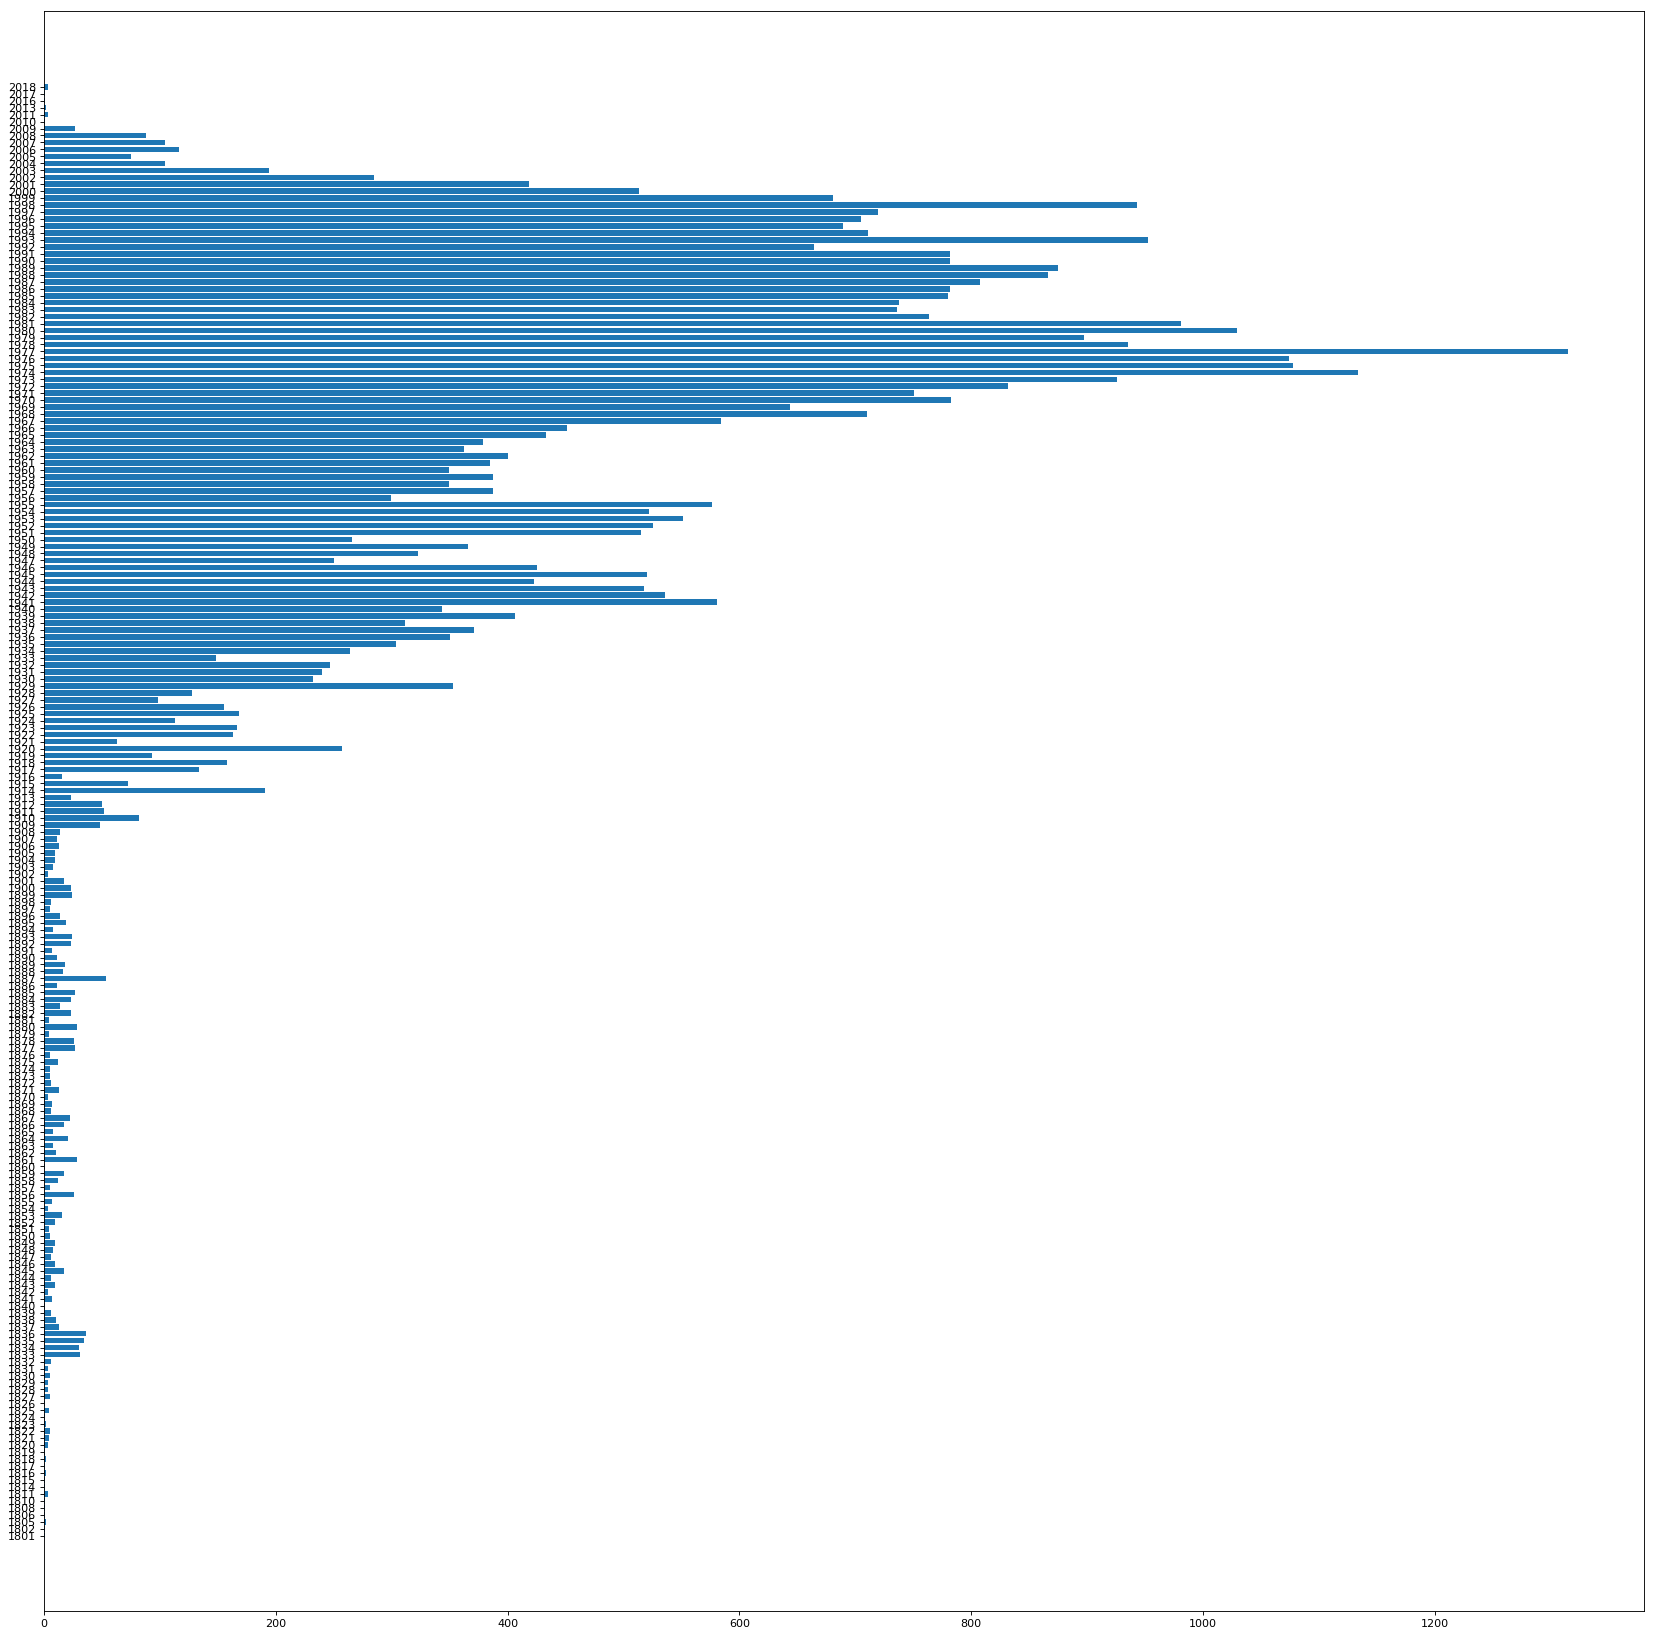

In [8]:
tmp = years.value_counts().sort_index()
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_axes([0,0,1,1])
ax.barh(tmp.index, tmp)
plt.show()

In [9]:
years = pd.to_numeric(years)
older = years[years<1978].count()
newer = years[years>=1978].count()
print(str(older) +' laws before 1977')
print(str(newer) +' laws after 1977')

27807 laws before 1977
19756 laws after 1977
